Plotter for Ugi Templated project. It generates a theoretical MA distribution histogram, a scatter plot for each of the conditions in the MS experiments and a histogram for the NMR analysis.

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from glob import glob
from os import path

font = {'family' : 'Arial',
        'size'   : 14}

plt.rc('font',**font)


Get MS folder and absolute path

In [10]:
#Absolute path
here = path.abspath('.')

#Folder containing .csv files extracted from LCMSanalyzer.ipynb
extracted_folder = path.join(here,'extracted')

files = glob(path.join(extracted_folder,'*.csv'))

#Move blank to the 4th position
files.insert(3, files.pop(6))


First, plot theoretical MA distribution from MA excel file

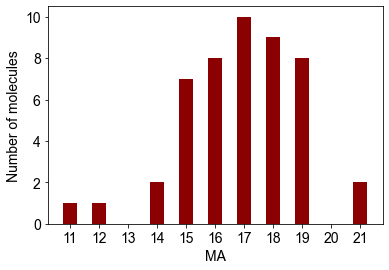

In [11]:
MA_df = pd.read_csv('products_MA.csv', encoding = 'utf-8')

#Take predicted MAs
MA = np.array(MA_df['MA'])

bins = np.arange(min(MA), max(MA)+2) - 0.5
plt.hist(MA, bins, rwidth= 0.5, color='darkred')
plt.xticks(range(min(MA), max(MA)+1),fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('MA',fontsize=14)
plt.ylabel('Number of molecules',fontsize=14)

plt.savefig(path.join(here,'Results','MAdistribution.png'))
plt.savefig(path.join(here,'Results','MAdistribution.svg'))




Create individual scatter plot for each individual MS result and plot them in the same figure

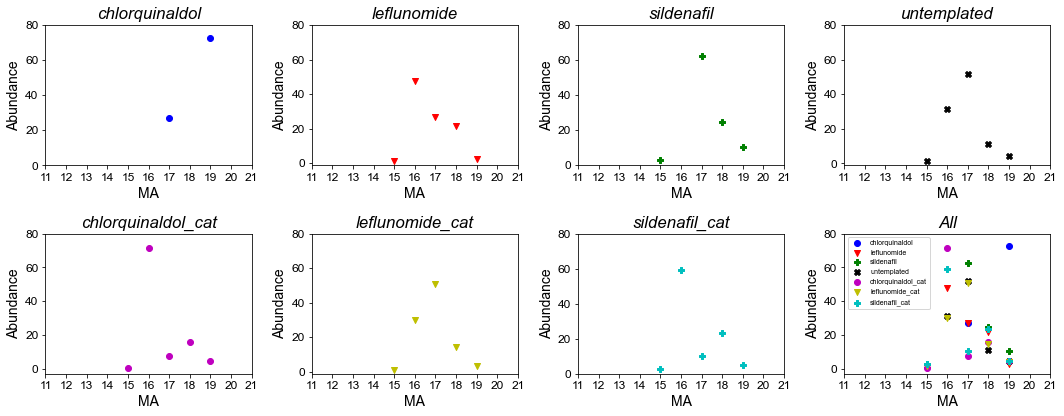

In [12]:
f, axs = plt.subplots(2,4,figsize=(15,6))

legend=['chlorquinaldol','leflunomide','sildenafil','untemplated','chlorquinaldol_cat','leflunomide_cat','sildenafil_cat']
markers = ['bo','rv','gP','kX','mo','yv','cP']

#Define a function to exctract the total abundance for each detected MA from MS file
def mas_extractor(filename):

    data = pd.read_csv(filename)

    mas = np.array(data['MA'])
    abundance = np.array(data['Abundance'])

    pairs = {}

    for i, ma in enumerate(mas):

        if ma not in pairs.keys():
            pairs[ma] = abundance[i]
        
        else:
            pairs[ma] += abundance[i]

    mas = [key for key,value in pairs.items()]
    abundance = [value for key,value in pairs.items()]
    
    return(mas, abundance)


for i, file in enumerate(files):
    
    ma,abundance = mas_extractor(file)
    plt.subplot(2,4,i+1)
    plt.scatter(ma,abundance, c=markers[i][0], marker= markers[i][1])
    plt.xticks(range(min(MA), max(MA)+1),fontsize=12)
    plt.yticks(range(0,100,20),fontsize=12)
    plt.xlabel('MA')
    plt.ylabel('Abundance')
    plt.title(legend[i], fontstyle='italic')

for i, file in enumerate(files):
    
    plt.subplot(2,4,8)
    ma,abundance = mas_extractor(file)
    plt.scatter(ma,abundance,c=markers[i][0], marker= markers[i][1])
    plt.xticks(range(min(MA), max(MA)+1),fontsize=12)
    plt.yticks(range(0,100,20),fontsize=12)
    plt.xlabel('MA')
    plt.ylabel('Abundance')
    plt.title('All', fontstyle='italic')
    plt.legend(legend, prop={'size':7})

f.tight_layout()
plt.savefig(path.join(here, 'Results', 'MS_plot.png'), dpi= 1000)
plt.savefig(path.join(here, 'Results','MS_plot.svg'), dpi= 1000)
    

Finally, NMR proton integration is plotted creating a function to group the integrated areas in 1 ppm bins and plot them as a histogram

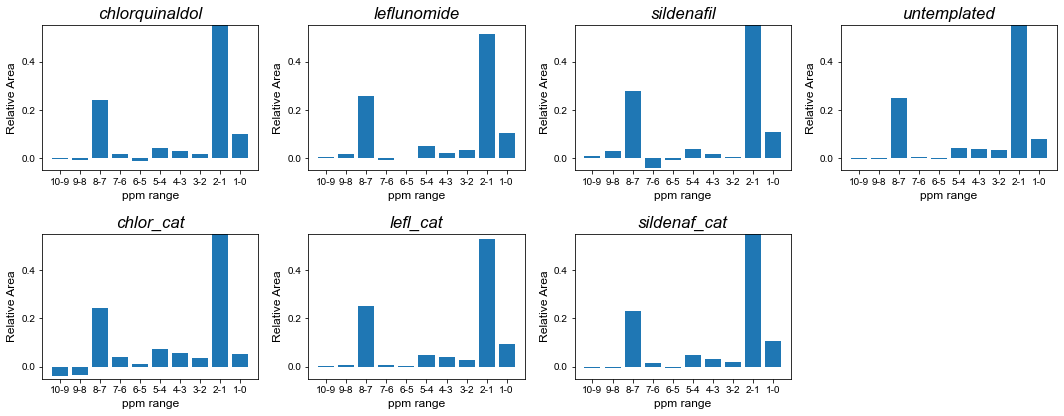

In [13]:
def proton_extractor(data):
    
    '''This function adds the integrated areas into 1 ppm bins and returns a list containing the 
    normalized areas values'''

    bins = []
    low = 0.0
    high = 1.0
    sum = 0

    for row in data.itertuples():
        upper =float(row[2][0:4])
        lower = float(row[2][-5:-1])
        
        if upper<=high and lower>=low:

            sum+=row[4]
            
        else:
            bins.append(sum)
            low+=1
            high+=1
            sum=row[4]
     
    if len(bins) != 10:
        bins.append(list(data['Absolute'])[-1])

    count=0

    for i in bins:
        count += i

    norm_bins = [i/count for i in bins]
    norm_bins.reverse()

    return norm_bins


#Plot histogram using the .xlsx file containing the integrated areas from MestreNova

f, axs = plt.subplots(2,4,figsize=(15,6))
x=[1,2,3,4,5,6,7,8,9,10]

legend=['chlorquinaldol','leflunomide','sildenafil','untemplated','chlor_cat','lefl_cat','sildenaf_cat']
ranges=['10-9','9-8','8-7','7-6','6-5','5-4','4-3','3-2','2-1','1-0']

for i in range(7):

    data = pd.read_excel('ProtonIntegration.xlsx', i)
        
    data=data.iloc[::-1]
    
    bins = proton_extractor(data)
 
    plt.subplot(2,4,i+1)
    plt.bar(x,bins)
    plt.xlabel('ppm range',fontsize=12)
    plt.xticks(x,ranges,fontsize=10)
    plt.yticks(fontsize=10)
    plt.ylim(-0.05,0.55)
    plt.ylabel('Relative Area',fontsize=12)
    plt.title(legend[i], fontstyle='italic')
    
f.delaxes(axs[1,3])  
f.tight_layout() 

f.savefig(path.join(here,'Results','ProtonIntegration.png'),dpi=1000)
f.savefig(path.join(here,'Results','ProtonIntegration.svg'),dpi=1000)
